### Magics

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepta' -d -t -v -p tensorflow,numpy,pandas,matplotlib -g

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Salomon Tetelepta 2019-10-06 08:54:07 

CPython 3.7.4
IPython 7.7.0

tensorflow 1.14.0
numpy 1.16.4
pandas 0.25.0
matplotlib 3.1.1
Git hash: 51c82ec9c1bc58508bc4355d528a4beb02bd6c43


### Imports

In [38]:
import os
import sys

import numpy as np
import pandas as pd
import cv2

import pickle

from pathlib import Path

# tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.keras.metrics import categorical_accuracy

# import DCNN model
from tensorflow.keras.applications import ResNet50

# import preprocessing functions for model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50


### Settings

In [39]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
model_path = project_path / "models"

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from set_cardgame.dataset import *
from set_cardgame.identify import *   
from set_cardgame.utils import *
from set_cardgame.findsets import *

# setup logger
logger = logging.getLogger(__name__)

### Load models

In [40]:
# load intermediate DCNN (ResNet50), outputs at best performing layer (stage 3, blockd, first conv layer)
dcnn_model_name = "resnet50-res3d_branch2a.h5"
intermediate_model = load_model(
    model_path / dcnn_model_name,
    custom_objects=None, 
    compile=True
)

# load linear classifier, trained with 8100 images
linear_classifier_model_name = "clf-lr-res3d_branch2a_8100.pkl"
with open(model_path / linear_classifier_model_name, 'rb') as handle:
    best_model = pickle.load(handle)

### Detect SET combinations

In [41]:
def read_image_with_cards(path_to_image, convert_to_rgb=True):
    img = cv2.imread(str(path_to_image))
    
    if convert_to_rgb:
        # convert image to rgb
        img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    return img

In [42]:
def plot_images(images, suptitle="", titles=None, ncols=5, figsize=(10, 10)):
    # images: list of images
    nr_images = len(images)
    nrows = np.ceil(nr_images / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    fig.suptitle(suptitle)
    for i, img in enumerate(images):
        if nrows > 1:
            r = i // ncols
            c = i % ncols
            ax = axs[r, c]
        else:
            ax = axs[i]
        if titles and len(titles) == nr_images:
            ax.set_title(titles[i])
        if len(img.shape) == 2:
            # grayscale image
            ax.imshow(img/255, cmap='gray')
        else:
            # rgb image
            ax.imshow(img/255)
    # hide the axis for all subplots
    [ax.set_axis_off() for ax in axs.ravel()]       
    return fig

===
processing: IMG_1838.JPG
mean of sorted contours top 20: 216192.125
median of sorted contours top 12 327525.0
std of sorted contours top 12: 26118.986902457837
total area of image: 12192768
ratio: s/l: 0.6585987261146496, area: 386718.0, area %: 3.17
ratio: s/l: 0.6508563899868248, area: 371627.5, area %: 3.05
ratio: s/l: 0.6328947368421053, area: 347760.5, area %: 2.85
ratio: s/l: 0.638700947225981, area: 340305.5, area %: 2.79
ratio: s/l: 0.6810584958217271, area: 338917.5, area %: 2.78
ratio: s/l: 0.6763485477178424, area: 335544.5, area %: 2.75
ratio: s/l: 0.6304044630404463, area: 319505.5, area %: 2.62
ratio: s/l: 0.6425648021828103, area: 318993.0, area %: 2.62
ratio: s/l: 0.6386206896551724, area: 318769.0, area %: 2.61
ratio: s/l: 0.6567375886524822, area: 311358.5, area %: 2.55
ratio: s/l: 0.6915052160953801, area: 303068.5, area %: 2.49
ratio: s/l: 0.6088193456614509, area: 293514.5, area %: 2.41
ratio: s/l: 0.38571428571428573, area: 45387.5, area %: 0.37
invalid ratio:

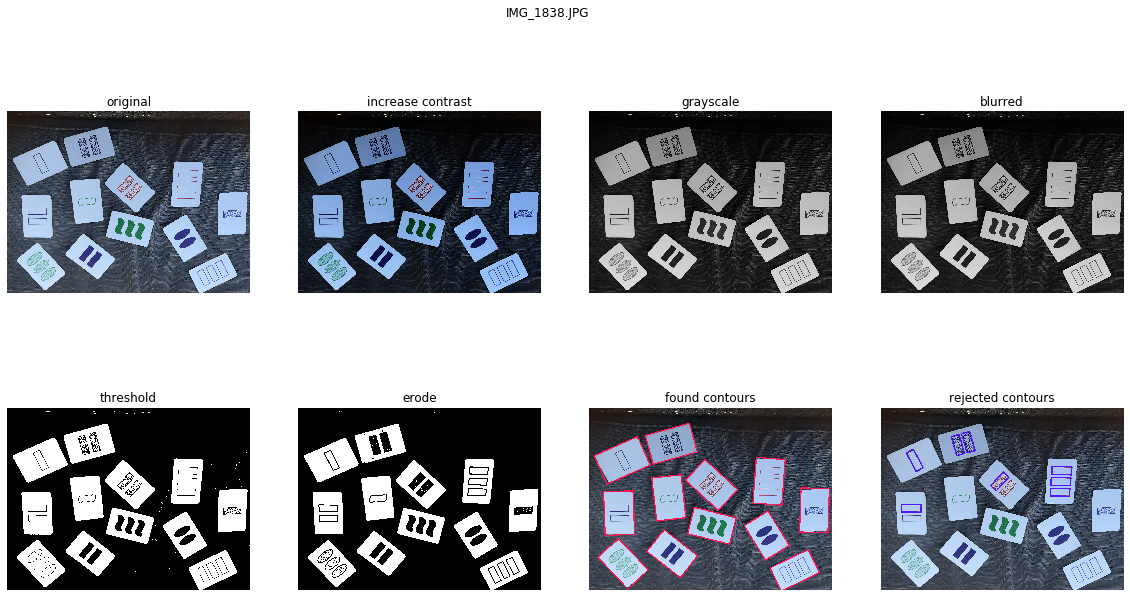

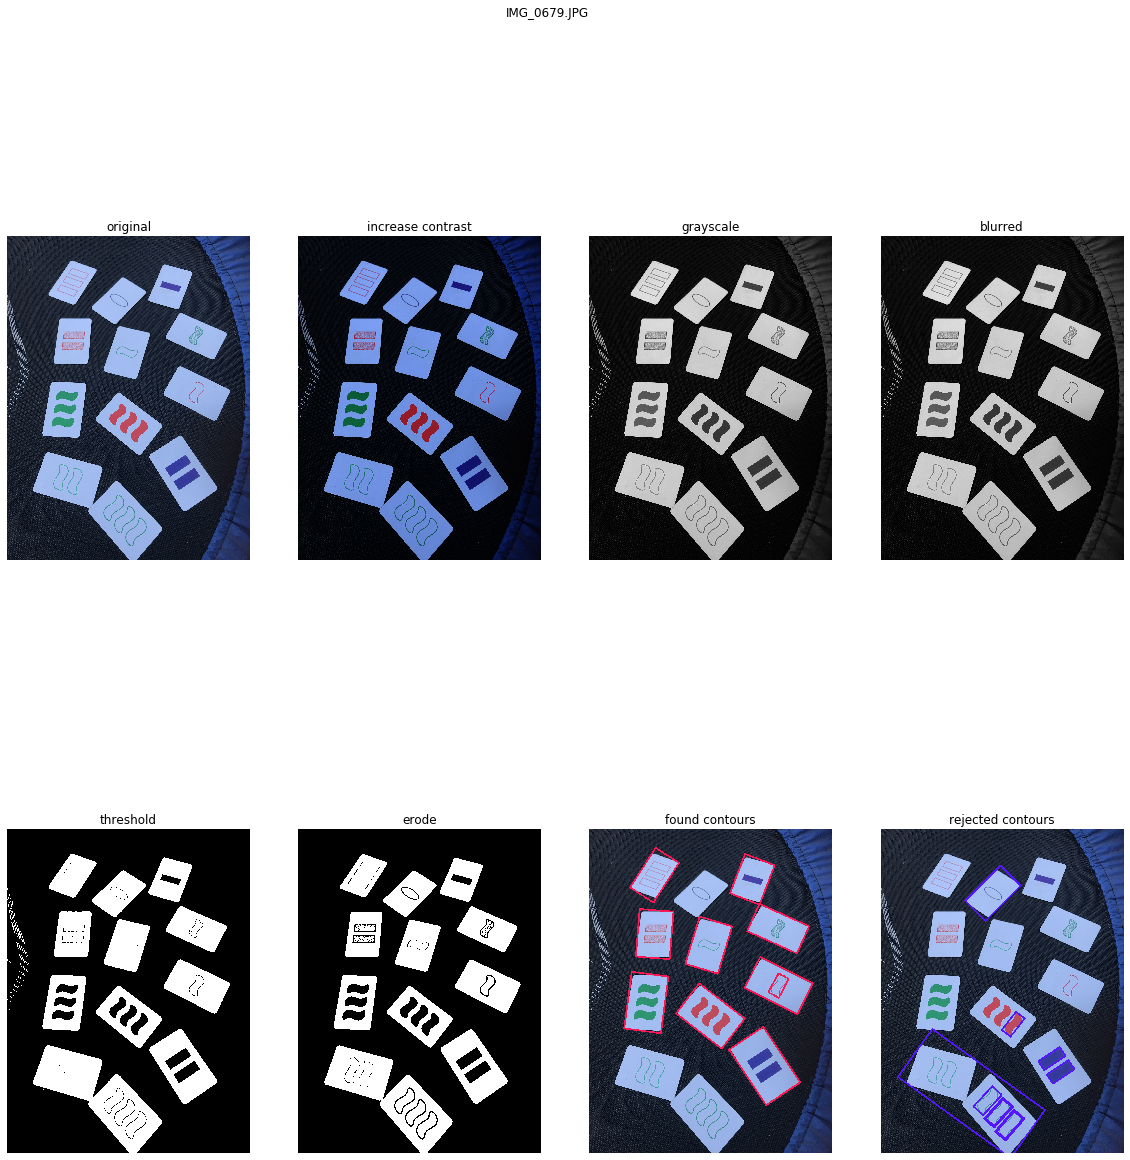

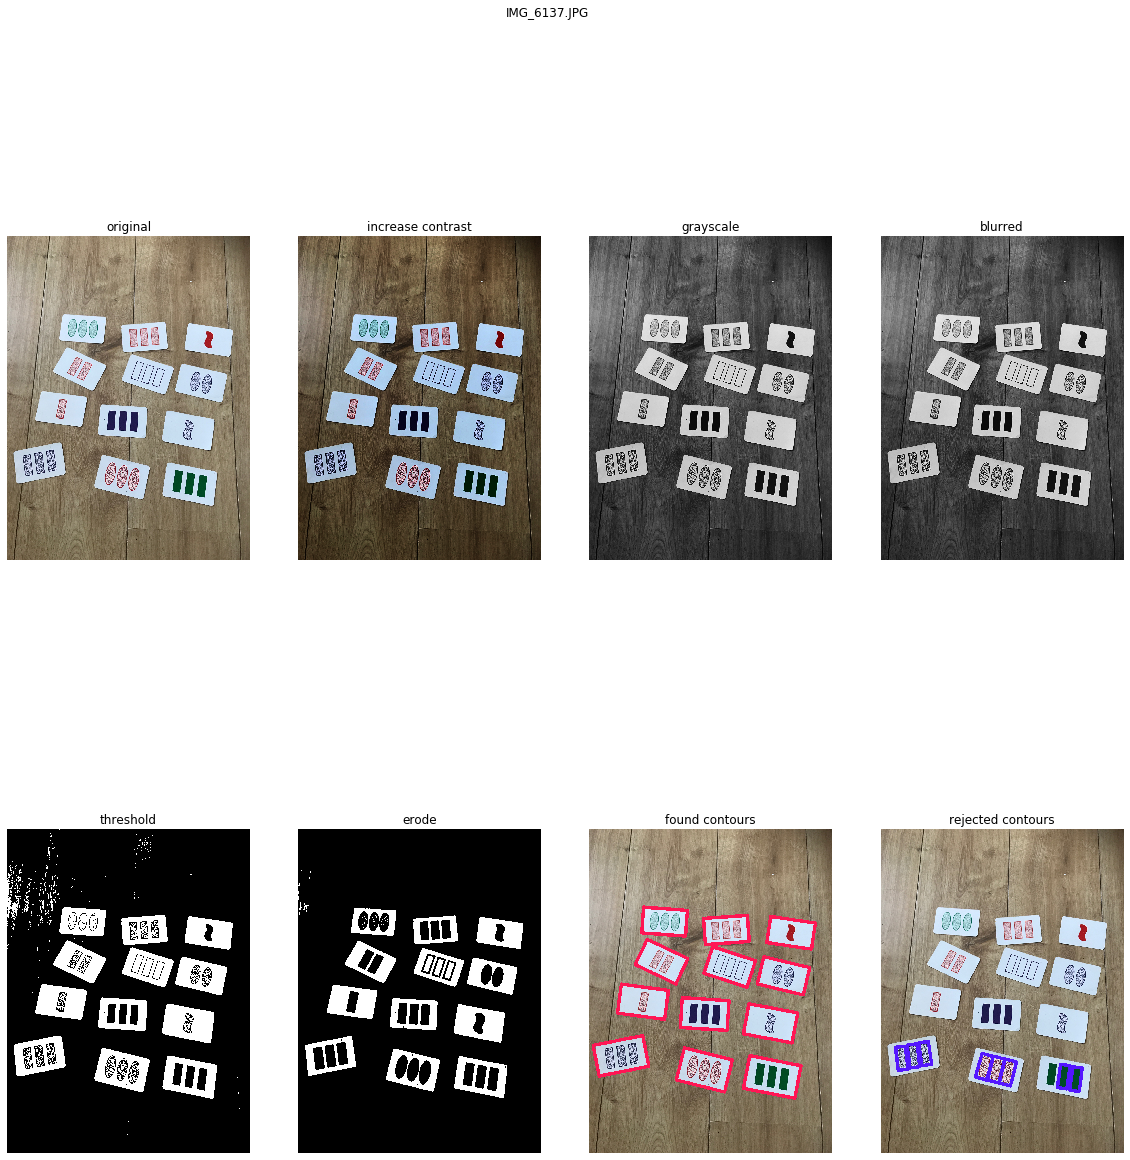

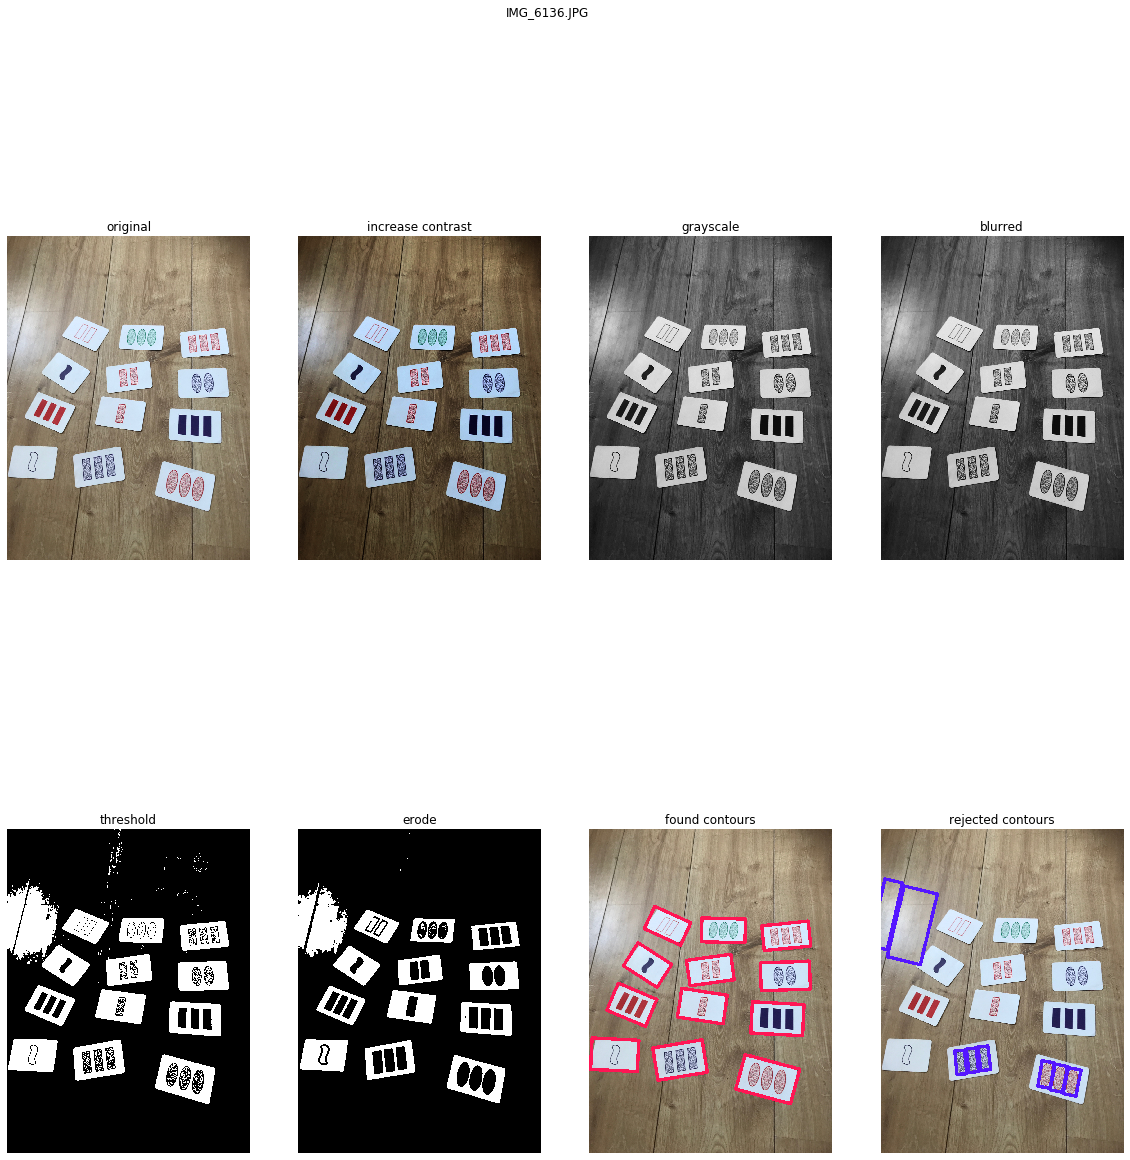

In [44]:
# putting it all together
test_images_path = project_path / "test_images"

# resize images to the input shape needed for the model
target_width, target_height = (128, 96)

# load meta data for the dataset (labels and features for each card type)
df_meta = load_metadata()

plot_intermediate_results = True

# loop throught all test images
for image_name in os.listdir(test_images_path):
    if image_name.lower().endswith('jpg'):
        print(f"===")
        print(f"processing: {image_name}")

        original_img = read_image_with_cards(test_images_path / image_name, convert_to_rgb=True)
        
        # identify the different cards
        identified_images, bboxes, rejected_bboxes, intermediate_steps = identify_images(original_img, target_size=(target_width, target_height))

        if plot_intermediate_results:
            # plot found contours
            img_contours = cv2.drawContours(original_img.copy(), bboxes, -1, (255, 22, 84), 20)
            img_contours_rejected = cv2.drawContours(original_img.copy(), rejected_bboxes, -1, (84, 22, 255), 20)
            
            if original_img.shape[0] > original_img.shape[1]:
                figsize=(20, 20)
            else:
                figsize=(20, 10)
                
            images_to_plot = [original_img] + intermediate_steps + [img_contours, img_contours_rejected]
            fig = plot_images(images_to_plot, 
                              suptitle=image_name,
                              titles=["original", "increase contrast", "grayscale", "blurred", "threshold", "erode", "found contours", "rejected contours"], 
                              ncols=4,
                              figsize=figsize
                  )
            plt.savefig(output_path / f"intermediate_{image_name}.png", bbox_inches='tight')
           
        nr_found_cards = len(identified_images)
        print(f"number of cards found: {nr_found_cards}")
        
#         # preprocess images
#         identified_images = preprocess_input_resnet50(identified_images.copy())
        
#         # generate image embeddings for each card
#         image_embeddings = intermediate_model.predict(identified_images).reshape(identified_images.shape[0], -1)

#         # classify cards
#         predictions = best_model.predict(image_embeddings)

#         # get feature codes for each prediction
#         predictions_features = get_feature_codes(df_meta, predictions)

#         if len(predictions_features) != len(np.unique(predictions_features, axis=0)):
#             print(f"found duplicate cards for {image_name}")
#             continue

#         # find all sets
#         sets = findsets(predictions_features)

#         # merge sets with the original image
#         set_images = merge_sets_with_image(img, image_name, bboxes, sets, line_color=(255, 22, 84))

#         # plot the merged images
#         nr_sets_found = len(set_images)

#         if nr_sets_found > 0:
#             print(f"nr sets found: {nr_sets_found}")
#             fig, axs = plt.subplots(nrows=1, ncols=nr_sets_found+1, figsize=(nr_sets_found*10, nr_sets_found*5))
#             fig.tight_layout()

#             # Make nice margins
#             plt.subplots_adjust(wspace=0.05)

#             # first image is the original
#             axs[0].imshow(img)
#             axs[0].set_title("Original", fontsize=32, fontweight="bold")
#             axs[0].axis('off')

#             # next images are found sets
#             for i, set_image in enumerate(set_images):
#                 print(f"SET {i+1}/{nr_sets_found}")
#                 for card in sets[i]:
#                     img_label = get_card_data(df_meta, predictions[card])['label']
#                     print(f"- {img_label}")
#                 axs[i+1].set_title(f"SET {i+1}/{nr_sets_found}", fontsize=32)
#                 axs[i+1].imshow(set_image)
#                 axs[i+1].axis('off')

#             # save and show images
#             plt.savefig(output_path / f"found_sets_{image_name}.png", bbox_inches='tight')
#             plt.show()

#         else:
#             print("no sets found")